In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/huan")

In [3]:
import dataloader
train_loader, val_loader, test_loader = dataloader.loadMNIST(data_dir="/content/drive/MyDrive/huan/data",
                                                        batch_size=64,
                                                        num_workers=4,
                                                        pin_memory=True,
                                                        val_ratio=0.15)

# class_names = [
#       "Angry",     # 0
#       "Disgust",   # 1
#       "Fear",      # 2
#       "Happy",     # 3
#       "Sad",       # 4
#       "Surprise",  # 5
#       "Neutral"    # 6
#   ]

class_names = [
      f"{i}" for i in range(10)
  ]

Train: 51000
Val: 9000
Test: 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
import Mymodel
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_models = 4
models = [Mymodel.load(len(class_names), device) for _ in range(num_models)]


Model: Model
Số tham số huấn luyện: 1,297,196
Model: Model
Số tham số huấn luyện: 1,297,196
Model: Model
Số tham số huấn luyện: 1,297,196
Model: Model
Số tham số huấn luyện: 1,297,196


In [5]:
import trainer
import torch.nn.functional as F
import torch.nn as nn
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        if weight is not None:
            self.weight = torch.tensor(weight, dtype=torch.float32)
        else:
            self.weight = None
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=1)   # (N, C)
        pt = torch.exp(logpt)                  # (N, C)

        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)  # (N,)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)        # (N,)

        if self.weight is not None:
            if self.weight.device != inputs.device:
                self.weight = self.weight.to(inputs.device)
            at = self.weight[targets]  # hệ số alpha theo class
        else:
            at = 1.0

        loss = - at * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

all_labels = []
for _, classData in train_loader:   # chỉ lấy nhãn, bỏ data
    all_labels.append(classData)

all_labels = torch.cat(all_labels)  # gộp tất cả nhãn lại
num_classes = len(torch.unique(all_labels))

# đếm số mẫu mỗi lớp
class_counts = torch.bincount(all_labels, minlength=num_classes).float()

# trọng số ngược với tần suất
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * num_classes  # chuẩn hóa

print("Class counts:", class_counts.tolist())
print("Class weights:", class_weights.tolist())

# truyền vào FocalLoss
criterion = FocalLoss(gamma=2, weight=class_weights)

trainer.training(
    model = models,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=200,
    optimizer=[torch.optim.AdamW(models[i].parameters(), lr=5e-4, weight_decay=0.01) for i in range(num_models)],
    scheduler=None,
    device=device,
    criterion=criterion,
    resultF='/content/drive/MyDrive/huan/base64d6n4_4_mnist.pth',
    continues = False,
    patience=30,
    delta=1e-4
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-488137154.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight = torch.tensor(weight, dtype=torch.float32)


Class counts: [5035.0, 5731.0, 5064.0, 5211.0, 4966.0, 4608.0, 5030.0, 5325.0, 4973.0, 5057.0]
Class weights: [1.0100741386413574, 0.8874058723449707, 1.0042896270751953, 0.9759591817855835, 1.0241085290908813, 1.1036725044250488, 1.011078119277954, 0.9550653696060181, 1.0226669311523438, 1.0056798458099365]


Epoch 1: 100%|██████████| 797/797 [01:39<00:00,  8.05batch/s]


Saved best model at epoch 1 with Val Acc: 0.9781
Epoch 1: Train Loss: 0.3287, Train Acc: 0.8756, Val Loss: 0.0548, Val Acc: 0.9781


Epoch 2: 100%|██████████| 797/797 [01:32<00:00,  8.58batch/s]


Saved best model at epoch 2 with Val Acc: 0.9861
Epoch 2: Train Loss: 0.0610, Train Acc: 0.9726, Val Loss: 0.0298, Val Acc: 0.9861


Epoch 3: 100%|██████████| 797/797 [01:33<00:00,  8.54batch/s]


Saved best model at epoch 3 with Val Acc: 0.9863
Epoch 3: Train Loss: 0.0403, Train Acc: 0.9796, Val Loss: 0.0237, Val Acc: 0.9863


Epoch 4: 100%|██████████| 797/797 [01:33<00:00,  8.53batch/s]


Saved best model at epoch 4 with Val Acc: 0.9894
Epoch 4: Train Loss: 0.0316, Train Acc: 0.9824, Val Loss: 0.0196, Val Acc: 0.9894


Epoch 5: 100%|██████████| 797/797 [01:35<00:00,  8.34batch/s]


Saved best model at epoch 5 with Val Acc: 0.9907
Epoch 5: Train Loss: 0.0266, Train Acc: 0.9851, Val Loss: 0.0161, Val Acc: 0.9907


Epoch 6: 100%|██████████| 797/797 [01:35<00:00,  8.30batch/s]


Saved best model at epoch 6 with Val Acc: 0.9922
Epoch 6: Train Loss: 0.0236, Train Acc: 0.9869, Val Loss: 0.0137, Val Acc: 0.9922


Epoch 7: 100%|██████████| 797/797 [01:36<00:00,  8.26batch/s]


Saved best model at epoch 7 with Val Acc: 0.9923
Epoch 7: Train Loss: 0.0210, Train Acc: 0.9881, Val Loss: 0.0134, Val Acc: 0.9923


Epoch 8: 100%|██████████| 797/797 [01:36<00:00,  8.29batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 8: Train Loss: 0.0187, Train Acc: 0.9895, Val Loss: 0.0131, Val Acc: 0.9923


Epoch 9: 100%|██████████| 797/797 [01:36<00:00,  8.25batch/s]


Saved best model at epoch 9 with Val Acc: 0.9942
Epoch 9: Train Loss: 0.0162, Train Acc: 0.9910, Val Loss: 0.0112, Val Acc: 0.9942


Epoch 10: 100%|██████████| 797/797 [01:36<00:00,  8.24batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 10: Train Loss: 0.0153, Train Acc: 0.9912, Val Loss: 0.0117, Val Acc: 0.9938


Epoch 11: 100%|██████████| 797/797 [01:33<00:00,  8.50batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 11: Train Loss: 0.0153, Train Acc: 0.9908, Val Loss: 0.0118, Val Acc: 0.9921


Epoch 12: 100%|██████████| 797/797 [01:32<00:00,  8.58batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 12: Train Loss: 0.0147, Train Acc: 0.9911, Val Loss: 0.0101, Val Acc: 0.9934


Epoch 13: 100%|██████████| 797/797 [01:32<00:00,  8.62batch/s]


No improvement for 4 epoch(s). Patience left: 26
Epoch 13: Train Loss: 0.0138, Train Acc: 0.9920, Val Loss: 0.0109, Val Acc: 0.9924


Epoch 14: 100%|██████████| 797/797 [01:33<00:00,  8.55batch/s]


No improvement for 5 epoch(s). Patience left: 25
Epoch 14: Train Loss: 0.0145, Train Acc: 0.9916, Val Loss: 0.0101, Val Acc: 0.9938


Epoch 15: 100%|██████████| 797/797 [01:33<00:00,  8.52batch/s]


No improvement for 6 epoch(s). Patience left: 24
Epoch 15: Train Loss: 0.0130, Train Acc: 0.9919, Val Loss: 0.0095, Val Acc: 0.9939


Epoch 16: 100%|██████████| 797/797 [01:34<00:00,  8.47batch/s]


No improvement for 7 epoch(s). Patience left: 23
Epoch 16: Train Loss: 0.0128, Train Acc: 0.9925, Val Loss: 0.0103, Val Acc: 0.9933


Epoch 17: 100%|██████████| 797/797 [01:33<00:00,  8.49batch/s]


No improvement for 8 epoch(s). Patience left: 22
Epoch 17: Train Loss: 0.0120, Train Acc: 0.9927, Val Loss: 0.0105, Val Acc: 0.9927


Epoch 18: 100%|██████████| 797/797 [01:32<00:00,  8.60batch/s]


No improvement for 9 epoch(s). Patience left: 21
Epoch 18: Train Loss: 0.0130, Train Acc: 0.9922, Val Loss: 0.0089, Val Acc: 0.9938


Epoch 19: 100%|██████████| 797/797 [01:34<00:00,  8.42batch/s]


No improvement for 10 epoch(s). Patience left: 20
Epoch 19: Train Loss: 0.0123, Train Acc: 0.9928, Val Loss: 0.0092, Val Acc: 0.9932


Epoch 20: 100%|██████████| 797/797 [01:35<00:00,  8.32batch/s]


Saved best model at epoch 20 with Val Acc: 0.9943
Epoch 20: Train Loss: 0.0112, Train Acc: 0.9929, Val Loss: 0.0093, Val Acc: 0.9943


Epoch 21: 100%|██████████| 797/797 [01:35<00:00,  8.36batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 21: Train Loss: 0.0115, Train Acc: 0.9929, Val Loss: 0.0079, Val Acc: 0.9941


Epoch 22: 100%|██████████| 797/797 [01:34<00:00,  8.43batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 22: Train Loss: 0.0106, Train Acc: 0.9939, Val Loss: 0.0091, Val Acc: 0.9940


Epoch 23: 100%|██████████| 797/797 [01:35<00:00,  8.38batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 23: Train Loss: 0.0109, Train Acc: 0.9934, Val Loss: 0.0088, Val Acc: 0.9938


Epoch 24: 100%|██████████| 797/797 [01:34<00:00,  8.42batch/s]


No improvement for 4 epoch(s). Patience left: 26
Epoch 24: Train Loss: 0.0104, Train Acc: 0.9937, Val Loss: 0.0088, Val Acc: 0.9941


Epoch 25: 100%|██████████| 797/797 [01:33<00:00,  8.51batch/s]


Saved best model at epoch 25 with Val Acc: 0.9944
Epoch 25: Train Loss: 0.0096, Train Acc: 0.9942, Val Loss: 0.0077, Val Acc: 0.9944


Epoch 26: 100%|██████████| 797/797 [01:34<00:00,  8.44batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 26: Train Loss: 0.0102, Train Acc: 0.9932, Val Loss: 0.0086, Val Acc: 0.9943


Epoch 27: 100%|██████████| 797/797 [01:34<00:00,  8.46batch/s]


Saved best model at epoch 27 with Val Acc: 0.9947
Epoch 27: Train Loss: 0.0094, Train Acc: 0.9941, Val Loss: 0.0084, Val Acc: 0.9947


Epoch 28: 100%|██████████| 797/797 [01:35<00:00,  8.33batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 28: Train Loss: 0.0092, Train Acc: 0.9945, Val Loss: 0.0085, Val Acc: 0.9940


Epoch 29: 100%|██████████| 797/797 [01:33<00:00,  8.53batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 29: Train Loss: 0.0103, Train Acc: 0.9933, Val Loss: 0.0091, Val Acc: 0.9946


Epoch 30: 100%|██████████| 797/797 [01:32<00:00,  8.60batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 30: Train Loss: 0.0099, Train Acc: 0.9936, Val Loss: 0.0083, Val Acc: 0.9943


Epoch 31: 100%|██████████| 797/797 [01:31<00:00,  8.69batch/s]


No improvement for 4 epoch(s). Patience left: 26
Epoch 31: Train Loss: 0.0092, Train Acc: 0.9941, Val Loss: 0.0079, Val Acc: 0.9947


Epoch 32: 100%|██████████| 797/797 [01:36<00:00,  8.23batch/s]


No improvement for 5 epoch(s). Patience left: 25
Epoch 32: Train Loss: 0.0095, Train Acc: 0.9939, Val Loss: 0.0082, Val Acc: 0.9946


Epoch 33: 100%|██████████| 797/797 [01:34<00:00,  8.40batch/s]


No improvement for 6 epoch(s). Patience left: 24
Epoch 33: Train Loss: 0.0093, Train Acc: 0.9943, Val Loss: 0.0079, Val Acc: 0.9943


Epoch 34: 100%|██████████| 797/797 [01:33<00:00,  8.49batch/s]


No improvement for 7 epoch(s). Patience left: 23
Epoch 34: Train Loss: 0.0096, Train Acc: 0.9939, Val Loss: 0.0075, Val Acc: 0.9943


Epoch 35: 100%|██████████| 797/797 [01:34<00:00,  8.43batch/s]


No improvement for 8 epoch(s). Patience left: 22
Epoch 35: Train Loss: 0.0084, Train Acc: 0.9947, Val Loss: 0.0079, Val Acc: 0.9943


Epoch 36: 100%|██████████| 797/797 [01:33<00:00,  8.56batch/s]


Saved best model at epoch 36 with Val Acc: 0.9950
Epoch 36: Train Loss: 0.0080, Train Acc: 0.9948, Val Loss: 0.0069, Val Acc: 0.9950


Epoch 37: 100%|██████████| 797/797 [01:33<00:00,  8.50batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 37: Train Loss: 0.0083, Train Acc: 0.9942, Val Loss: 0.0083, Val Acc: 0.9940


Epoch 38: 100%|██████████| 797/797 [01:32<00:00,  8.61batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 38: Train Loss: 0.0079, Train Acc: 0.9949, Val Loss: 0.0073, Val Acc: 0.9944


Epoch 39: 100%|██████████| 797/797 [01:35<00:00,  8.33batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 39: Train Loss: 0.0079, Train Acc: 0.9950, Val Loss: 0.0069, Val Acc: 0.9950


Epoch 40: 100%|██████████| 797/797 [01:35<00:00,  8.36batch/s]


Saved best model at epoch 40 with Val Acc: 0.9953
Epoch 40: Train Loss: 0.0079, Train Acc: 0.9948, Val Loss: 0.0072, Val Acc: 0.9953


Epoch 41: 100%|██████████| 797/797 [01:37<00:00,  8.21batch/s]


Saved best model at epoch 41 with Val Acc: 0.9958
Epoch 41: Train Loss: 0.0078, Train Acc: 0.9952, Val Loss: 0.0070, Val Acc: 0.9958


Epoch 42: 100%|██████████| 797/797 [01:36<00:00,  8.28batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 42: Train Loss: 0.0078, Train Acc: 0.9946, Val Loss: 0.0069, Val Acc: 0.9951


Epoch 43: 100%|██████████| 797/797 [01:34<00:00,  8.47batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 43: Train Loss: 0.0076, Train Acc: 0.9949, Val Loss: 0.0063, Val Acc: 0.9951


Epoch 44: 100%|██████████| 797/797 [01:33<00:00,  8.53batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 44: Train Loss: 0.0075, Train Acc: 0.9954, Val Loss: 0.0064, Val Acc: 0.9952


Epoch 45: 100%|██████████| 797/797 [01:34<00:00,  8.47batch/s]


No improvement for 4 epoch(s). Patience left: 26
Epoch 45: Train Loss: 0.0071, Train Acc: 0.9951, Val Loss: 0.0077, Val Acc: 0.9949


Epoch 46: 100%|██████████| 797/797 [01:33<00:00,  8.52batch/s]


No improvement for 5 epoch(s). Patience left: 25
Epoch 46: Train Loss: 0.0078, Train Acc: 0.9950, Val Loss: 0.0062, Val Acc: 0.9950


Epoch 47: 100%|██████████| 797/797 [01:33<00:00,  8.52batch/s]


No improvement for 6 epoch(s). Patience left: 24
Epoch 47: Train Loss: 0.0074, Train Acc: 0.9950, Val Loss: 0.0067, Val Acc: 0.9949


Epoch 48: 100%|██████████| 797/797 [01:33<00:00,  8.56batch/s]


No improvement for 7 epoch(s). Patience left: 23
Epoch 48: Train Loss: 0.0069, Train Acc: 0.9954, Val Loss: 0.0070, Val Acc: 0.9949


Epoch 49: 100%|██████████| 797/797 [01:37<00:00,  8.18batch/s]


No improvement for 8 epoch(s). Patience left: 22
Epoch 49: Train Loss: 0.0063, Train Acc: 0.9957, Val Loss: 0.0083, Val Acc: 0.9928


Epoch 50: 100%|██████████| 797/797 [01:35<00:00,  8.36batch/s]


Saved best model at epoch 50 with Val Acc: 0.9962
Epoch 50: Train Loss: 0.0064, Train Acc: 0.9958, Val Loss: 0.0060, Val Acc: 0.9962


Epoch 51: 100%|██████████| 797/797 [01:36<00:00,  8.23batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 51: Train Loss: 0.0063, Train Acc: 0.9956, Val Loss: 0.0060, Val Acc: 0.9958


Epoch 52: 100%|██████████| 797/797 [01:36<00:00,  8.23batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 52: Train Loss: 0.0065, Train Acc: 0.9955, Val Loss: 0.0063, Val Acc: 0.9949


Epoch 53: 100%|██████████| 797/797 [01:34<00:00,  8.40batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 53: Train Loss: 0.0059, Train Acc: 0.9961, Val Loss: 0.0064, Val Acc: 0.9960


Epoch 54: 100%|██████████| 797/797 [01:33<00:00,  8.52batch/s]


No improvement for 4 epoch(s). Patience left: 26
Epoch 54: Train Loss: 0.0062, Train Acc: 0.9956, Val Loss: 0.0069, Val Acc: 0.9949


Epoch 55: 100%|██████████| 797/797 [01:35<00:00,  8.30batch/s]


No improvement for 5 epoch(s). Patience left: 25
Epoch 55: Train Loss: 0.0064, Train Acc: 0.9954, Val Loss: 0.0065, Val Acc: 0.9958


Epoch 56: 100%|██████████| 797/797 [01:35<00:00,  8.32batch/s]


No improvement for 6 epoch(s). Patience left: 24
Epoch 56: Train Loss: 0.0062, Train Acc: 0.9955, Val Loss: 0.0058, Val Acc: 0.9958


Epoch 57: 100%|██████████| 797/797 [01:35<00:00,  8.34batch/s]


No improvement for 7 epoch(s). Patience left: 23
Epoch 57: Train Loss: 0.0064, Train Acc: 0.9957, Val Loss: 0.0056, Val Acc: 0.9952


Epoch 58: 100%|██████████| 797/797 [01:38<00:00,  8.13batch/s]


No improvement for 8 epoch(s). Patience left: 22
Epoch 58: Train Loss: 0.0055, Train Acc: 0.9963, Val Loss: 0.0057, Val Acc: 0.9954


Epoch 59: 100%|██████████| 797/797 [01:37<00:00,  8.21batch/s]


No improvement for 9 epoch(s). Patience left: 21
Epoch 59: Train Loss: 0.0064, Train Acc: 0.9956, Val Loss: 0.0066, Val Acc: 0.9951


Epoch 60: 100%|██████████| 797/797 [01:37<00:00,  8.18batch/s]


Saved best model at epoch 60 with Val Acc: 0.9963
Epoch 60: Train Loss: 0.0063, Train Acc: 0.9959, Val Loss: 0.0053, Val Acc: 0.9963


Epoch 61: 100%|██████████| 797/797 [01:36<00:00,  8.22batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 61: Train Loss: 0.0062, Train Acc: 0.9955, Val Loss: 0.0061, Val Acc: 0.9956


Epoch 62: 100%|██████████| 797/797 [01:35<00:00,  8.36batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 62: Train Loss: 0.0055, Train Acc: 0.9960, Val Loss: 0.0064, Val Acc: 0.9958


Epoch 63: 100%|██████████| 797/797 [01:32<00:00,  8.61batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 63: Train Loss: 0.0057, Train Acc: 0.9960, Val Loss: 0.0054, Val Acc: 0.9962


Epoch 64: 100%|██████████| 797/797 [01:32<00:00,  8.61batch/s]


Saved best model at epoch 64 with Val Acc: 0.9968
Epoch 64: Train Loss: 0.0053, Train Acc: 0.9961, Val Loss: 0.0048, Val Acc: 0.9968


Epoch 65: 100%|██████████| 797/797 [01:33<00:00,  8.50batch/s]


No improvement for 1 epoch(s). Patience left: 29
Epoch 65: Train Loss: 0.0053, Train Acc: 0.9964, Val Loss: 0.0061, Val Acc: 0.9947


Epoch 66: 100%|██████████| 797/797 [01:33<00:00,  8.54batch/s]


No improvement for 2 epoch(s). Patience left: 28
Epoch 66: Train Loss: 0.0050, Train Acc: 0.9961, Val Loss: 0.0059, Val Acc: 0.9959


Epoch 67: 100%|██████████| 797/797 [01:35<00:00,  8.31batch/s]


No improvement for 3 epoch(s). Patience left: 27
Epoch 67: Train Loss: 0.0049, Train Acc: 0.9964, Val Loss: 0.0057, Val Acc: 0.9958


Epoch 68: 100%|██████████| 797/797 [01:36<00:00,  8.25batch/s]


No improvement for 4 epoch(s). Patience left: 26
Epoch 68: Train Loss: 0.0054, Train Acc: 0.9960, Val Loss: 0.0063, Val Acc: 0.9956


Epoch 69: 100%|██████████| 797/797 [01:36<00:00,  8.26batch/s]


No improvement for 5 epoch(s). Patience left: 25
Epoch 69: Train Loss: 0.0051, Train Acc: 0.9965, Val Loss: 0.0055, Val Acc: 0.9959


Epoch 70: 100%|██████████| 797/797 [01:33<00:00,  8.54batch/s]


No improvement for 6 epoch(s). Patience left: 24
Epoch 70: Train Loss: 0.0048, Train Acc: 0.9966, Val Loss: 0.0054, Val Acc: 0.9962


Epoch 71: 100%|██████████| 797/797 [01:34<00:00,  8.44batch/s]


No improvement for 7 epoch(s). Patience left: 23
Epoch 71: Train Loss: 0.0046, Train Acc: 0.9966, Val Loss: 0.0058, Val Acc: 0.9962


Epoch 72: 100%|██████████| 797/797 [01:35<00:00,  8.36batch/s]


No improvement for 8 epoch(s). Patience left: 22
Epoch 72: Train Loss: 0.0052, Train Acc: 0.9963, Val Loss: 0.0055, Val Acc: 0.9961


Epoch 73: 100%|██████████| 797/797 [01:35<00:00,  8.36batch/s]


No improvement for 9 epoch(s). Patience left: 21
Epoch 73: Train Loss: 0.0052, Train Acc: 0.9961, Val Loss: 0.0054, Val Acc: 0.9956


Epoch 74: 100%|██████████| 797/797 [01:35<00:00,  8.33batch/s]


No improvement for 10 epoch(s). Patience left: 20
Epoch 74: Train Loss: 0.0047, Train Acc: 0.9967, Val Loss: 0.0054, Val Acc: 0.9957


Epoch 75: 100%|██████████| 797/797 [01:34<00:00,  8.45batch/s]


No improvement for 11 epoch(s). Patience left: 19
Epoch 75: Train Loss: 0.0040, Train Acc: 0.9973, Val Loss: 0.0048, Val Acc: 0.9962


Epoch 76: 100%|██████████| 797/797 [01:35<00:00,  8.36batch/s]


No improvement for 12 epoch(s). Patience left: 18
Epoch 76: Train Loss: 0.0047, Train Acc: 0.9966, Val Loss: 0.0057, Val Acc: 0.9954


Epoch 77: 100%|██████████| 797/797 [01:34<00:00,  8.41batch/s]


No improvement for 13 epoch(s). Patience left: 17
Epoch 77: Train Loss: 0.0041, Train Acc: 0.9971, Val Loss: 0.0053, Val Acc: 0.9960


Epoch 78: 100%|██████████| 797/797 [01:34<00:00,  8.41batch/s]


No improvement for 14 epoch(s). Patience left: 16
Epoch 78: Train Loss: 0.0041, Train Acc: 0.9967, Val Loss: 0.0051, Val Acc: 0.9966


Epoch 79: 100%|██████████| 797/797 [01:35<00:00,  8.37batch/s]


No improvement for 15 epoch(s). Patience left: 15
Epoch 79: Train Loss: 0.0043, Train Acc: 0.9969, Val Loss: 0.0052, Val Acc: 0.9963


Epoch 80: 100%|██████████| 797/797 [01:35<00:00,  8.31batch/s]


No improvement for 16 epoch(s). Patience left: 14
Epoch 80: Train Loss: 0.0041, Train Acc: 0.9969, Val Loss: 0.0056, Val Acc: 0.9967


Epoch 81: 100%|██████████| 797/797 [01:34<00:00,  8.45batch/s]


No improvement for 17 epoch(s). Patience left: 13
Epoch 81: Train Loss: 0.0042, Train Acc: 0.9971, Val Loss: 0.0053, Val Acc: 0.9960


Epoch 82: 100%|██████████| 797/797 [01:34<00:00,  8.42batch/s]


No improvement for 18 epoch(s). Patience left: 12
Epoch 82: Train Loss: 0.0038, Train Acc: 0.9973, Val Loss: 0.0049, Val Acc: 0.9966


Epoch 83: 100%|██████████| 797/797 [01:35<00:00,  8.32batch/s]


No improvement for 19 epoch(s). Patience left: 11
Epoch 83: Train Loss: 0.0040, Train Acc: 0.9971, Val Loss: 0.0055, Val Acc: 0.9957


Epoch 84: 100%|██████████| 797/797 [01:35<00:00,  8.35batch/s]


No improvement for 20 epoch(s). Patience left: 10
Epoch 84: Train Loss: 0.0042, Train Acc: 0.9971, Val Loss: 0.0051, Val Acc: 0.9958


Epoch 85: 100%|██████████| 797/797 [01:36<00:00,  8.28batch/s]


No improvement for 21 epoch(s). Patience left: 9
Epoch 85: Train Loss: 0.0038, Train Acc: 0.9973, Val Loss: 0.0050, Val Acc: 0.9961


Epoch 86: 100%|██████████| 797/797 [01:35<00:00,  8.31batch/s]


No improvement for 22 epoch(s). Patience left: 8
Epoch 86: Train Loss: 0.0041, Train Acc: 0.9969, Val Loss: 0.0050, Val Acc: 0.9967


Epoch 87: 100%|██████████| 797/797 [01:34<00:00,  8.44batch/s]


No improvement for 23 epoch(s). Patience left: 7
Epoch 87: Train Loss: 0.0038, Train Acc: 0.9973, Val Loss: 0.0053, Val Acc: 0.9959


Epoch 88: 100%|██████████| 797/797 [01:34<00:00,  8.45batch/s]


No improvement for 24 epoch(s). Patience left: 6
Epoch 88: Train Loss: 0.0039, Train Acc: 0.9971, Val Loss: 0.0053, Val Acc: 0.9960


Epoch 89: 100%|██████████| 797/797 [01:34<00:00,  8.42batch/s]


No improvement for 25 epoch(s). Patience left: 5
Epoch 89: Train Loss: 0.0036, Train Acc: 0.9974, Val Loss: 0.0054, Val Acc: 0.9963


Epoch 90: 100%|██████████| 797/797 [01:34<00:00,  8.42batch/s]


No improvement for 26 epoch(s). Patience left: 4
Epoch 90: Train Loss: 0.0035, Train Acc: 0.9972, Val Loss: 0.0049, Val Acc: 0.9960


Epoch 91: 100%|██████████| 797/797 [01:34<00:00,  8.45batch/s]


No improvement for 27 epoch(s). Patience left: 3
Epoch 91: Train Loss: 0.0034, Train Acc: 0.9972, Val Loss: 0.0049, Val Acc: 0.9960


Epoch 92: 100%|██████████| 797/797 [01:34<00:00,  8.43batch/s]


No improvement for 28 epoch(s). Patience left: 2
Epoch 92: Train Loss: 0.0036, Train Acc: 0.9973, Val Loss: 0.0045, Val Acc: 0.9959


Epoch 93: 100%|██████████| 797/797 [01:34<00:00,  8.42batch/s]


No improvement for 29 epoch(s). Patience left: 1
Epoch 93: Train Loss: 0.0033, Train Acc: 0.9975, Val Loss: 0.0053, Val Acc: 0.9956


Epoch 94: 100%|██████████| 797/797 [01:33<00:00,  8.55batch/s]


No improvement for 30 epoch(s). Patience left: 0
Epoch 94: Train Loss: 0.0034, Train Acc: 0.9975, Val Loss: 0.0057, Val Acc: 0.9954
Early stopping at epoch 94. Best Val Acc: 0.9968


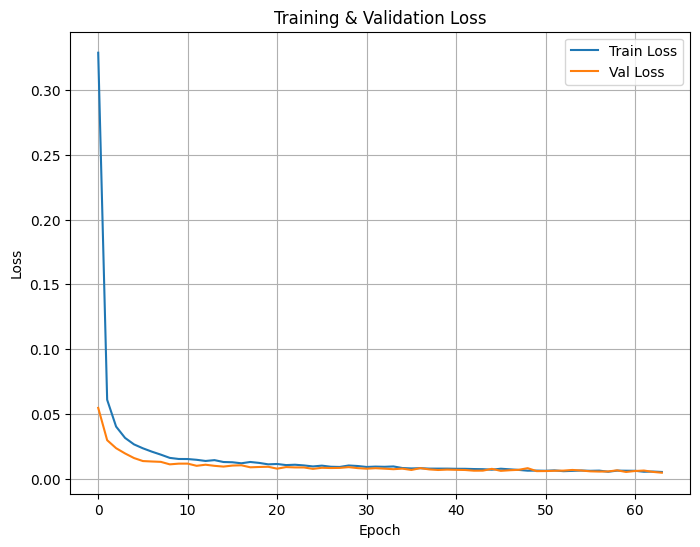

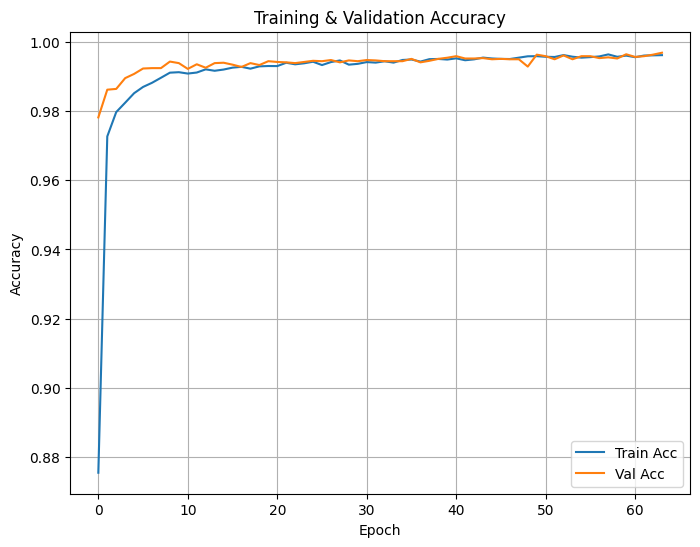

100%|██████████| 157/157 [00:05<00:00, 28.19batch/s]


=== Kết quả tổng hợp ===
Accuracy: 0.9973
Macro Precision: 0.9973
Macro Recall: 0.9972
Macro F1: 0.9973

=== Kết quả cho từng lớp ===
Lớp 0: Precision=0.9980, Recall=1.0000, F1=0.9990
Lớp 1: Precision=0.9965, Recall=0.9991, F1=0.9978
Lớp 2: Precision=0.9971, Recall=0.9990, F1=0.9981
Lớp 3: Precision=0.9961, Recall=1.0000, F1=0.9980
Lớp 4: Precision=0.9939, Recall=0.9990, F1=0.9964
Lớp 5: Precision=0.9955, Recall=0.9955, F1=0.9955
Lớp 6: Precision=0.9990, Recall=0.9937, F1=0.9963
Lớp 7: Precision=0.9981, Recall=0.9961, F1=0.9971
Lớp 8: Precision=1.0000, Recall=0.9969, F1=0.9985
Lớp 9: Precision=0.9990, Recall=0.9931, F1=0.9960

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
          

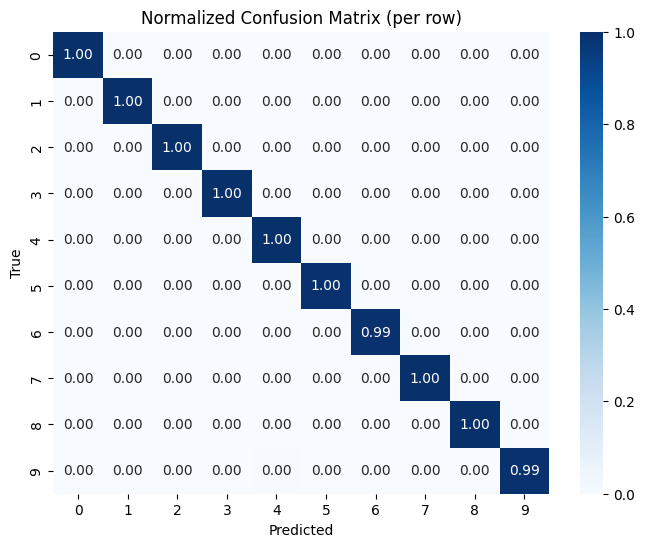

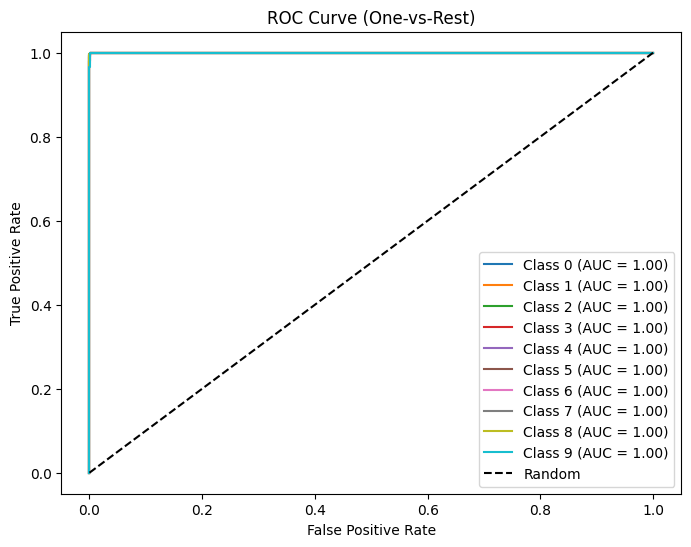

In [6]:
import trainer
trainer.evaluate(
    model=models,
    class_names = class_names,
    test_loader=test_loader,
    device=device,
    resultF="/content/drive/MyDrive/huan/base64d6n4_4_mnist.pth"
)